## 汽油辛烷值优化建模

以下解题过程中：
+ 参数定义
    - 《附件一：325个样本数据.xlsx》以符号 $\displaystyle{\mathcal{X}}_{s}$ 表示
    - 《附件三：285号和313号样本原始数据.xlsx》以符号 $\displaystyle{\mathcal{X}}_{r}$ 表示

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import stats

mpl.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 配置显示中文，否则乱码
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号，如果是plt画图，则将mlp换成plt

In [2]:
sample_data = "../附件一：325个样本数据.xlsx"
raw_data = "../附件三：285号和313号样本原始数据.xlsx"
adjust_data = "../附件四：354个操作变量信息.xlsx"

In [3]:
raws = pd.read_excel(io=raw_data, sheet_name="操作变量", header=[0, 1], skiprows=[0])
samples = pd.read_excel(io=sample_data, header=[0, 1], skiprows=[0])

# 查看 原始数据情况
# raws.iloc[:5, :16] 
# 查看 样本数据情况
# samples.iloc[:5, :16] 

### 问题一：

数据处理：请参考近4年的工业数据(见附件一“325个数据样本数据.xlsx”)的预处理结果，依“样本确定方法”（附件二）对285号和313号数据样本进行预处理（原始数据见附件三“285号和313号样本原始数据.xlsx”）并将处理后的数据分别加入到附件一中相应的样本号中，供下面研究使用。

即 数据预处理 ====> 补全数据&修正数据

解题思路：

+ 认真阅读《附件二：样本确定方法.docx》
+ 补全数据：
    - 即需要先确认 样本数据集 $\displaystyle{\mathcal{X}}_{s}$ 中 285号 $x_{s}^{(285)}$ 和 313号 $x_{s}^{(313)}$ 存在属性值缺失的属性集合 $\displaystyle{\mathcal{D}}_{loss}$
    - 将缺失的属性集合 $\displaystyle{\mathcal{D}}_{loss}$ 中的缺失的属性值从 原始数据集 $\displaystyle{\mathcal{X}}_{r}$ 中以求取均值 mean($\displaystyle{\mathcal{V}_{r}}$) 的方式确定
+ 修正数据：
    - 即需要先确认 原始数据集 $\displaystyle{\mathcal{X}}_{r}$ 中 285号 $x_{s}^{(285)}$ 和 313号 $x_{s}^{(313)}$ 样本中各属性的属性值缺失情况，对于缺失情况较大的属性则不对 样本数据集 $\displaystyle{\mathcal{X}}_{s}$ 中的 属性值 $\displaystyle{\mathcal{D}}$ 进行修正
    - 将 285号 $x_{s}^{(285)}$ 和 313号 $x_{s}^{(313)}$ 样本中需要修正的属性采用 变异系数 std($\displaystyle{\mathcal{V}_{r}}$)/mean($\displaystyle{\mathcal{V}_{r}}$) 来判断数据的离散程度，然后依据 正态分布假设检验 $norm(d \sim (mean(\displaystyle{\mathcal{V}_{r}})，std(\displaystyle{\mathcal{V}_{r}})))$，然后使用 依达拉原则 剔除一些不在范围内的样本，然后进行求取均值的操作

代码逻辑：

+ 补全数据：
    - 首先从 样本数据集 $\displaystyle{\mathcal{X}}_{s}$ 中确定样本 285号 $x_{s}^{(285)}$ 和 313号 $x_{s}^{(313)}$ 缺失的属性 $\displaystyle{\mathcal{D}}_{loss}$
    - 然后对缺失的属性 $d_{loss} \in \displaystyle{\mathcal{D}}_{loss}$ 对应到 原始数据集 $\displaystyle{\mathcal{X}}_{r}$ 中，逐一对每个缺失的属性值进行判别
    - 这里使用 $\frac{\displaystyle{\mathbb{I}}(v_{loss}^{(i)} \ne 0|d_{loss}^{(i)}  \in \displaystyle{\mathcal{D}}_{loss})}{\displaystyle{\mathbb{I}}(v_{loss}^{(i)} |d_{loss}^{(i)} \in \displaystyle{\mathcal{D}}_{loss})}$ 对当前 缺失的属性 $d_{loss}$ 在 原始数据集 $\displaystyle{\mathcal{X}}_{r}$ 中数据采集的状况进行评估
        + 当比值 $ \ge \frac{3}{4} $ 时，对当前 缺失的属性的值 $\displaystyle{\mathcal{V}_{d_{loss}}}$ 进行求均值 mean($\displaystyle{\mathcal{V}_{d_{loss}}}$) 处理；
        + 当比值 $ < \frac{3}{4} $ 时，对当前 缺失的属性 $d_{loss}$ 进行直接忽略处理；

+ 修正数据：
    + 对样本 $x_{s}^{(i)}$ 进行 缺失的属性 $d_{loss}$ 求均值之前需进行异常值处理
        - 根据拉依达准则（3$\sigma$准则）去除异常值，得到 缺失的属性 $d_{loss}$ 对应的过滤后的 原始属性值集合 $\displaystyle{\mathcal{V}}_{filter}^{d_{loss}}$
        - 将处理后的 原始属性值集合 $\displaystyle{\mathcal{V}}_{filter}^{d_{loss}}$ 中的属性值进行求 均值 $\displaystyle{\mathcal{V}}_{filter_{mean}}^{d_{loss}}$ 操作加入到 $\displaystyle{\mathcal{X}}_{s}$ 中对应的 样本数据 $x_{s}^{(i)}$ 对应的 缺失的属性 $d_{loss}$ 中

In [4]:
# No.285 样本
sample_285 = samples.iloc[284]
sample_285 = sample_285.drop(index=sample_285.index[[x for x in range(1, 16)]], axis=1)
# No.313 样本
sample_313 = samples.iloc[312]
sample_313 = sample_313.drop(index=sample_285.index[[x for x in range(1, 16)]], axis=1)

# 查看 No.285 数据情况
# sample_285
# 查看 No.313 数据情况
# sample_313

In [5]:
def find_dummy_colmuns(sample):
    dummy_columns = []
    for (code_name, i18n_name) in sample.keys():
        if not sample[(code_name, i18n_name)]:
            # 查看 样本属性值 为 0 的列名
            # print(f"{'='*10}{i18n_name}{'='*10}")
            # print(f"{code_name}: => {sample[(code_name, i18n_name)]}")
            # print(f"{'='*35}")
            dummy_columns.append(code_name)
    return dummy_columns

In [6]:
sample_285_dummy_columns = find_dummy_colmuns(sample_285)
sample_313_dummy_columns = find_dummy_colmuns(sample_313)

# 查看 No.285 属性值为空的情况
print(f"No.285 属性值为空的列: {sample_285_dummy_columns}")
# 查看 No.313 属性值为空的情况
print(f"No.313 属性值为空的列: {sample_313_dummy_columns}")

No.285 属性值为空的列: ['S-ZORB.FT_1501.PV', 'S-ZORB.FT_1002.PV', 'S-ZORB.FC_1202.PV', 'S-ZORB.FT_1501.TOTAL', 'S-ZORB.FT_5102.PV', 'S-ZORB.FT_2901.DACA', 'S-ZORB.FC_1104.DACA', 'S-ZORB.FT_2803.DACA', 'S-ZORB.FT_1502.DACA', 'S-ZORB.TEX_3103A.DACA', 'S-ZORB.FT_5102.DACA.PV']
No.313 属性值为空的列: ['S-ZORB.FT_1501.PV', 'S-ZORB.FT_1002.PV', 'S-ZORB.FT_1501.TOTAL', 'S-ZORB.FT_2901.DACA', 'S-ZORB.FC_1104.DACA', 'S-ZORB.FT_2803.DACA', 'S-ZORB.FT_1502.DACA', 'S-ZORB.TEX_3103A.DACA']


In [7]:
# 拆分原始数据中285号样本的数据
print("拆分出来的285号样本的原始数据")
raw_285 = raws.iloc[:40]
raw_285[sample_285_dummy_columns].head(n=5)

拆分出来的285号样本的原始数据


,S-ZORB.FT_1501.PV,S-ZORB.FT_1002.PV,S-ZORB.FC_1202.PV,S-ZORB.FT_1501.TOTAL,S-ZORB.FT_5102.PV,S-ZORB.FT_2901.DACA,S-ZORB.FC_1104.DACA,S-ZORB.FT_2803.DACA,S-ZORB.FT_1502.DACA,S-ZORB.TEX_3103A.DACA,S-ZORB.FT_5102.DACA.PV
,新氢进装置流量,1#催化汽油进装置流量,D121顶去放火炬流量,新氢进装置流量,Unnamed: 110_level_1,D-109松动风流量,进料调节阀旁路流量,紧急氢气去D-102流量,补充氢压缩机出口返回管流量,EH-102加热元件/A束温度,D-201含硫污水排量
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# 拆分原始数据中313号样本的数据
print("拆分出来的313号样本的原始数据")
raw_313 = raws.iloc[41:]
raw_313[sample_313_dummy_columns].head(n=5)

拆分出来的313号样本的原始数据


,S-ZORB.FT_1501.PV,S-ZORB.FT_1002.PV,S-ZORB.FT_1501.TOTAL,S-ZORB.FT_2901.DACA,S-ZORB.FC_1104.DACA,S-ZORB.FT_2803.DACA,S-ZORB.FT_1502.DACA,S-ZORB.TEX_3103A.DACA
,新氢进装置流量,1#催化汽油进装置流量,新氢进装置流量,D-109松动风流量,进料调节阀旁路流量,紧急氢气去D-102流量,补充氢压缩机出口返回管流量,EH-102加热元件/A束温度
41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


至此对于原始数据中的 补全数据操作 完成，可惜的是从结果看起来上面所罗列的原始数据并没有对285号和313号样本的缺失的属性值有所帮助

接下来将以原始数据集展开对样本数据集中285号和313号样本的属性值进行修正操作，值得庆幸的是，这一步可以省略上面已经验证的无法补全的一些缺失属性

In [9]:
# 统计 No.285 样本 中属性中属性值存在空值的属性
raw_285 = raw_285.drop(raw_285[sample_285_dummy_columns], axis=1)
raw_285_nonzeroratio = raw_285.astype(bool).sum(axis=0) / 40
raw_285_dummy_columns = []
for (code_name, i18n_name) in raw_285_nonzeroratio.keys():
    if raw_285_nonzeroratio[(code_name, i18n_name)] != 1.0:
        raw_285_dummy_columns.append(code_name)
print(raw_285_dummy_columns)

[]


In [10]:
# 依据 拉依达准则 对 No.285 样本进行属性值数据修正
raw_285_filter = raw_285.replace(0, np.NaN)
raw_285_filter_describe = raw_285_filter.describe()
temp_ratio = raw_285_filter_describe.loc['std'] / raw_285_filter_describe.loc['mean']
for (code_name, i18n_name) in temp_ratio.keys():
    if temp_ratio[(code_name, i18n_name)] > 0.3:
        norm_test = stats.kstest(raw_285_filter[(code_name, i18n_name)], 'norm', (raw_285_filter_describe.loc['mean', (code_name, i18n_name)], raw_285_filter_describe.loc['std', (code_name, i18n_name)]))
        if norm_test.pvalue > 0.05:
            print(f"{'='*10} code_name: {code_name} {'='*10}")
            print(f"样本数据 参照 => {sample_313[(code_name, i18n_name)]}")
            print(f"原始数据 均值 => {raw_285_filter_describe.loc['mean', (code_name, i18n_name)]}")
            print(f"原始数据 方差 => {raw_285_filter_describe.loc['std', (code_name, i18n_name)]}")
            print(f"{'-'*40}")
            print(f"变异系数 => {temp_ratio[(code_name, i18n_name)]}")
            print(f"正态检验 => {norm_test.pvalue}")
            print(f"正态分布检验成功，依据3σ原则进行修正")
            temp_data = raw_285_filter[(code_name, i18n_name)][np.abs(raw_285_filter[(code_name, i18n_name)] - raw_285_filter_describe.loc['mean', (code_name, i18n_name)]) <= 3 * raw_285_filter_describe.loc['std', (code_name, i18n_name)]]
            print(f"修正数据 均值 => {temp_data.mean()}")
            sample_285[(code_name, i18n_name)] = temp_data.mean()
            print(f"样本数据 修正 => {sample_285[(code_name, i18n_name)]}")
        else:
            print(f"正态分布检验失败，不对样本数据进行修正")
        print(f"{'='*40}")
    else:
        sample_285[(code_name, i18n_name)] = raw_285_filter_describe.loc['mean', (code_name, i18n_name)]

In [11]:
# 统计 No.313 样本 中属性中属性值存在空值的属性
raw_313 = raw_313.drop(raw_313[sample_313_dummy_columns], axis=1)
raw_313_nonzeroratio = raw_313.astype(bool).sum(axis=0) / 40
raw_313_dummy_columns = []
for (code_name, i18n_name) in raw_313_nonzeroratio.keys():
    if raw_313_nonzeroratio[(code_name, i18n_name)] != 1.0:
        raw_313_dummy_columns.append(code_name)
print(raw_313_dummy_columns)

['S-ZORB.FT_1204.PV', 'S-ZORB.FC_2432.DACA', 'S-ZORB.FT_2431.DACA', 'S-ZORB.FC_2432.PIDA.SP', 'S-ZORB.FT_1204.DACA.PV']


<AxesSubplot:>

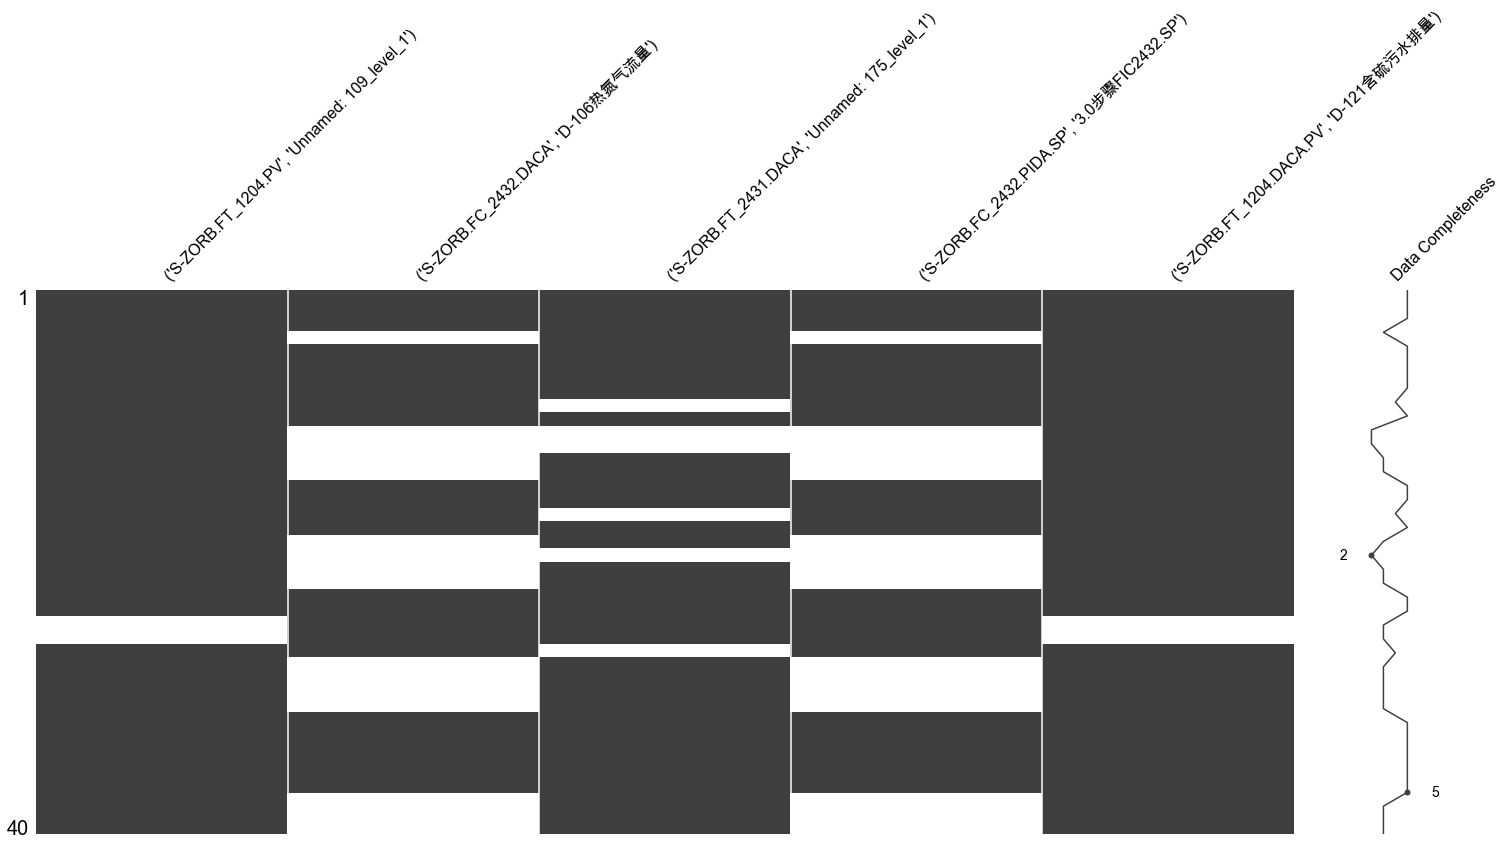

In [12]:
# 可视化呈现 No.313 样本 中属性中属性值存在空值的属性的分布
import missingno as msno
%matplotlib inline
msno.matrix(raw_313[raw_313_dummy_columns].replace(0, np.nan), labels=True)

In [13]:
# 对 No.313 样本中 存在属性值缺失的 属性进行统计学描述
dummy_raw_313 = raw_313[raw_313_dummy_columns].replace(0, np.NaN)
dummy_raw_313.describe()

,S-ZORB.FT_1204.PV,S-ZORB.FC_2432.DACA,S-ZORB.FT_2431.DACA,S-ZORB.FC_2432.PIDA.SP,S-ZORB.FT_1204.DACA.PV
,Unnamed: 109_level_1,D-106热氮气流量,Unnamed: 175_level_1,3.0步骤FIC2432.SP,D-121含硫污水排量
count,38.000000,24.000000,34.000000,24.000000,38.000000
mean,49.707433,55.025050,255.479771,55.977408,49.707433
std,8.341846,25.134146,234.464315,25.826184,8.341846
min,6.597014,0.488710,3.981225,0.177480,6.597014
25%,46.641427,38.959682,90.305070,39.000000,46.641427
50%,51.932390,68.763040,197.265750,69.000000,51.932390
75%,53.980428,74.201170,333.157850,79.000000,53.980428
max,57.424220,80.166200,937.010600,79.000000,57.424220


In [14]:
# 依据 拉依达准则 对 No.313 样本进行属性值数据修正
# 变异系数 用来衡量 数据的扩散程度
abnormal_ratio1 = 0.3  # 需要调整模型的时候参数
raw_313_filter = raw_313.drop(raw_313[['S-ZORB.FT_2431.DACA']], axis=1).replace(0, np.NaN)
raw_313_filter_describe = raw_313_filter.describe()
temp_ratio = raw_313_filter_describe.loc['std'] / raw_313_filter_describe.loc['mean']
for (code_name, i18n_name) in temp_ratio.keys():
    if temp_ratio[(code_name, i18n_name)] > abnormal_ratio1:
        norm_test = stats.kstest(raw_313_filter[(code_name, i18n_name)], 'norm', (raw_313_filter_describe.loc['mean', (code_name, i18n_name)], raw_313_filter_describe.loc['std', (code_name, i18n_name)]))
        if norm_test.pvalue > 0.05:
            print(f"{'='*10} code_name: {code_name} {'='*10}")
            print(f"样本数据 参照 => {sample_313[(code_name, i18n_name)]}")
            print(f"原始数据 均值 => {raw_313_filter_describe.loc['mean', (code_name, i18n_name)]}")
            print(f"原始数据 方差 => {raw_313_filter_describe.loc['std', (code_name, i18n_name)]}")
            print(f"{'-'*40}")
            print(f"变异系数 => {temp_ratio[(code_name, i18n_name)]}")
            print(f"正态检验 => {norm_test.pvalue}")
            print(f"正态分布检验成功，依据3σ原则进行修正")
            temp_data = raw_313_filter[(code_name, i18n_name)][np.abs(raw_313_filter[(code_name, i18n_name)] - raw_313_filter_describe.loc['mean', (code_name, i18n_name)]) <= 3 * raw_313_filter_describe.loc['std', (code_name, i18n_name)]]
            print(f"修正数据 均值 => {temp_data.mean()}")
            sample_313[(code_name, i18n_name)] = temp_data.mean()
            print(f"样本数据 修正 => {sample_313[(code_name, i18n_name)]}")
            print(f"{'='*40}")
    else:
        sample_313[(code_name, i18n_name)] = raw_313_filter_describe.loc['mean', (code_name, i18n_name)]

========== code_name: S-ZORB.PDC_2502.PV ==========
样本数据 参照 => 44.47553984299999
原始数据 均值 => 44.475539843
原始数据 方差 => 32.09303634057142
----------------------------------------
变异系数 => 0.7215884608452379
正态检验 => 0.23137618121257653
正态分布检验成功，依据3σ原则进行修正
修正数据 均值 => 44.475539843
样本数据 修正 => 44.475539843
========== code_name: S-ZORB.PDT_3602.DACA ==========
样本数据 参照 => 0.25898975500000004
原始数据 均值 => 0.258989755
原始数据 方差 => 0.12831749812724835
----------------------------------------
变异系数 => 0.4954539538726092
正态检验 => 0.24438277364119265
正态分布检验成功，依据3σ原则进行修正
修正数据 均值 => 0.258989755
样本数据 修正 => 0.258989755
========== code_name: S-ZORB.LT_9101.DACA ==========
样本数据 参照 => 1.6824734924999998
原始数据 均值 => 1.6824734925000002
原始数据 方差 => 2.109765974373722
----------------------------------------
变异系数 => 1.2539668433282742
正态检验 => 0.1964290696460399
正态分布检验成功，依据3σ原则进行修正
修正数据 均值 => 1.6824734925000002
样本数据 修正 => 1.6824734925000002
========== code_name: S-ZORB.PC_2401.PIDA.OP ==========
样本数据 参照 => 49.24353829999999

### 问题二：

寻找建模主要变量：建立降低辛烷值损失模型涉及包括7个原料性质、2个待生吸附剂性质、2个再生吸附剂性质、2个产品性质等变量以及另外354个操作变量（共计367个变量），工程技术应用中经常使用先降维后建模的方法，这有利于忽略次要因素，发现并分析影响模型的主要变量与因素。因此，请你们根据提供的325个样本数据（见附件一），通过降维的方法从367个操作变量中筛选出建模主要变量，使之尽可能具有代表性、独立性（为了工程应用方便，建议降维后的主要变量在30个以下），并请详细说明建模主要变量的筛选过程及其合理性。（提示：请考虑将原料的辛烷值作为建模变量之一）。

即 特征工程 -- 特征选择&数据降维

解题思路：
+ 题意 = 建模(7个原料性质 + 2个待生吸附剂性质 + 2个再生吸附剂性质 + 2个产品性质 + 降维(354个操作变量)) => 2个产品性质
+ 特征选择
    - 数据值是否缺失过多：如果一个特征的样本数据缺失较多，则无法统计其对目标的影响，将该变量删除
        - 具体方法：分别统计操作变量的缺失值数量，然后计算其在数据中的比例，超过一定比例的特征可以删除
    - 特征是否发散：如果一个特征不发散，也就是说样本在这个特征上基本上没有差异，这个特征对于样本的区分并没有什么用
        - 具体方法：分别计算操作变量的方差，按方差的大小（需要结合《附件四：354个操作变量信息.xlsx》中的变量阈值进行归一化处理）进行排序（从大到小排），末尾删除一定数量
    - 特征与目标的相关性：这点比较显见，与目标相关性高的特征，应当优选选择，反之则相反
        - 具体方法：利用决策树算法，即采用方差的方法对特征值进行判别，每次选取一个特征值时会

> 在特征选择步骤中如果处理后存在未删除的缺失数据，需要考虑对缺失数据的补充，可以考虑对该数据的分布进行概率分布建模（例如：高斯分布）来确定其值，需要，即在进行数据降维操作之前，需要对数据完整性进行保证

+ 数据降维 (需要注意：“它们的操作变量（控制变量）之间具有高度非线性和相互强耦联的关系”题干中已经明确说明了)
    - 特征之间的相关性：因为操作变量之间是非线性关系，因此无法使用常规的线性降维方式，需要采用流形学习和核化方式对操作变量进行降维
        - 具体方法：利用t-SNE对操作变量进行降维
        

In [15]:
# 将 No.285 样本和 No.313 样本的修正数据替换到 样本数据 中
samples.iloc[284] = sample_285
samples.iloc[312] = sample_313

samples.iloc[:5, 16:23]

,S-ZORB.CAL_H2.PV,S-ZORB.PDI_2102.PV,S-ZORB.PT_2801.PV,S-ZORB.FC_2801.PV,S-ZORB.TE_2103.PV,S-ZORB.TE_2005.PV,S-ZORB.PT_2101.PV
,氢油比,反应过滤器压差,还原器压力,还原器流化氢气流量,反应器上部温度,反应器底部温度,反应器顶部压力
0,0.276318,31.211968,2.526857,647.752380,424.615900,421.608145,2.393991
1,0.277127,31.461969,2.527411,651.821920,420.953385,417.927830,2.394113
2,0.277013,31.339998,2.528865,650.747150,423.941065,420.003515,2.394545
3,0.277222,31.033443,2.530589,652.669055,423.722805,419.964775,2.392854
4,0.277310,30.826894,2.530938,649.340920,427.132000,422.128935,2.392715


In [16]:
samples.shape

(325, 370)

In [17]:
# 尝试对 样本数据 原料性质 进行一个3σ检验用来剔除异常样本记录
source_samples = samples[samples.columns[[x for x in range(2, 9)]]]
source_samples_describe = source_samples.describe()
for (code_name, i18n_name) in source_samples.keys():
    norm_test = stats.kstest(source_samples[(code_name, i18n_name)], 'norm', (source_samples_describe.loc['mean', (code_name, i18n_name)], source_samples_describe.loc['std', (code_name, i18n_name)]))
    if norm_test.pvalue > 0.05:
        print(f"正态分布检验成功，依据3σ原则进行修正")
    else:
        pass
# 不符合正态分布

In [18]:
def reshape_limit_minmax(column_name):
    samples.drop(samples[column_name].idxmax(), inplace=True)
    samples.drop(samples[column_name].idxmin(), inplace=True)

In [19]:
# 没有形成合适的正态分布，因此使用 变异系数 加 最大最小限幅降低 样本数据的 变异系数
# 变异系数 用来衡量 数据的扩散程度
abnormal_ratio2 = 0.15  # 需要调整模型的时候参数
temp_ratio = source_samples_describe.loc['std'] / source_samples_describe.loc['mean']
for (code_name, i18n_name) in temp_ratio.keys():
    while temp_ratio[(code_name, i18n_name)] > abnormal_ratio2:
        reshape_limit_minmax((code_name, i18n_name))
        source_samples = samples[samples.columns[[x for x in range(2, 9)]]]
        source_samples_describe = source_samples.describe()
        temp_ratio = source_samples_describe.loc['std'] / source_samples_describe.loc['mean']
    print(f"原料属性: {i18n_name} 调整后 变异系数：{temp_ratio[(code_name, i18n_name)]}")

原料属性: 硫含量,μg/g 调整后 变异系数：0.14911123864049403
原料属性: 辛烷值RON 调整后 变异系数：0.00946920379517574
原料属性: 饱和烃,v%（烷烃+环烷烃） 调整后 变异系数：0.08590854234248488
原料属性: 烯烃,v% 调整后 变异系数：0.14814356866776127
原料属性: 芳烃,v% 调整后 变异系数：0.0788605680763621
原料属性: 溴值
,gBr/100g 调整后 变异系数：0.14436227020995843
原料属性: 密度(20℃),
kg/m³ 调整后 变异系数：0.005710728684513356


In [20]:
samples.shape

(181, 370)

In [21]:
# 查询 样本数据 的 零值占比
samples_nonzeroratio = samples.astype(bool).sum(axis=0) / samples.shape[0]
samples_dummy_columns = []
for (code_name, i18n_name) in samples_nonzeroratio.keys():
    if samples_nonzeroratio[(code_name, i18n_name)] != 1.0:
        print(f"{code_name}[{i18n_name}]:  => nonzero_ratio: {samples_nonzeroratio[(code_name, i18n_name)]}")
        samples_dummy_columns.append((code_name, i18n_name))

S-ZORB.FC_2301.PV[D105流化氢气流量]:  => nonzero_ratio: 0.5138121546961326
S-ZORB.FT_9301.PV[蒸汽进装置流量]:  => nonzero_ratio: 0.9834254143646409
S-ZORB.FT_1501.PV[新氢进装置流量]:  => nonzero_ratio: 0.1270718232044199
S-ZORB.FT_5104.PV[轻烃出装置流量]:  => nonzero_ratio: 0.6464088397790055
S-ZORB.FT_9101.PV[污油出装置]:  => nonzero_ratio: 0.5359116022099447
S-ZORB.FT_9402.PV[非净化风进装置流量]:  => nonzero_ratio: 0.994475138121547
S-ZORB.FT_1002.PV[1#催化汽油进装置流量]:  => nonzero_ratio: 0.6077348066298343
S-ZORB.FT_1004.PV[3#催化汽油进装置流量]:  => nonzero_ratio: 0.988950276243094
S-ZORB.FC_1202.PV[D121顶去放火炬流量]:  => nonzero_ratio: 0.3259668508287293
S-ZORB.FC_3103.PV[再生冷氮气流量]:  => nonzero_ratio: 0.24861878453038674
S-ZORB.FT_1002.TOTAL[0]:  => nonzero_ratio: 0.39779005524861877
S-ZORB.FT_1501.TOTAL[新氢进装置流量]:  => nonzero_ratio: 0.6519337016574586
S-ZORB.FT_5102.PV[0]:  => nonzero_ratio: 0.6519337016574586
S-ZORB.FT_2901.DACA[D-109松动风流量]:  => nonzero_ratio: 0.6077348066298343
S-ZORB.FC_2432.DACA[D-106热氮气流量]:  => nonzero_ratio: 0.99447513

检查下面的变量取值范围是否包含0

+ ('S-ZORB.FC_2301.PV', 'D105流化氢气流量')                    0-350
+ ('S-ZORB.FT_1501.PV', '新氢进装置流量')                      0-3500
+ ('S-ZORB.FT_5104.PV', '轻烃出装置流量')                     0-3500
+ ('S-ZORB.FT_9101.PV', '污油出装置')                         0-85
+ ('S-ZORB.FT_1002.PV', '1#催化汽油进装置流量')               0-140
+ ('S-ZORB.FT_1004.PV', '3#催化汽油进装置流量')                 0-90
+ ('S-ZORB.FC_1202.PV', 'D121顶去放火炬流量')                0-300
+ ('S-ZORB.FC_3103.PV', '再生冷氮气流量')                     0-80
+ ('S-ZORB.FT_1002.TOTAL', 0)                            0-620
+ ('S-ZORB.FT_1501.TOTAL', '新氢进装置流量')                0-55000000
+ ('S-ZORB.FT_5102.PV', 0)                                   0-450
+ ('S-ZORB.FT_2901.DACA', 'D-109松动风流量'),                   0-30
+ ('S-ZORB.FT_2002.DACA', '热循环气去R101底提升气管流量')        0-400
+ ('S-ZORB.FC_1104.DACA', '进料调节阀旁路流量')                  0-1
+ ('S-ZORB.FT_2803.DACA', '紧急氢气去D-102流量')                0-3
+ ('S-ZORB.FT_1502.DACA', '补充氢压缩机出口返回管流量')          0-2500
+ ('S-ZORB.FT_3702.DACA', '闭锁料斗H2过滤器出口气流量')           0-60
+ ('S-ZORB.TEX_3103A.DACA', 'EH-102加热元件/A束温度')           0-100
+ ('S-ZORB.FT_5102.DACA.PV', 'D-201含硫污水排量')              0-420
+ ('S-ZORB.FT_1006.DACA.PV', '加氢裂化轻石脑油进装置流量')       0-12000
+ ('S-ZORB.FT_5204.DACA.PV', '汽油产品去气分流量')               0-2500

即存在零值的属性其值域都包含了零，但是考虑到上述属性值值域范围在边界的情况下才为0，因此不考虑其取零值的情况，只作为缺失的情况进行考虑

<AxesSubplot:>

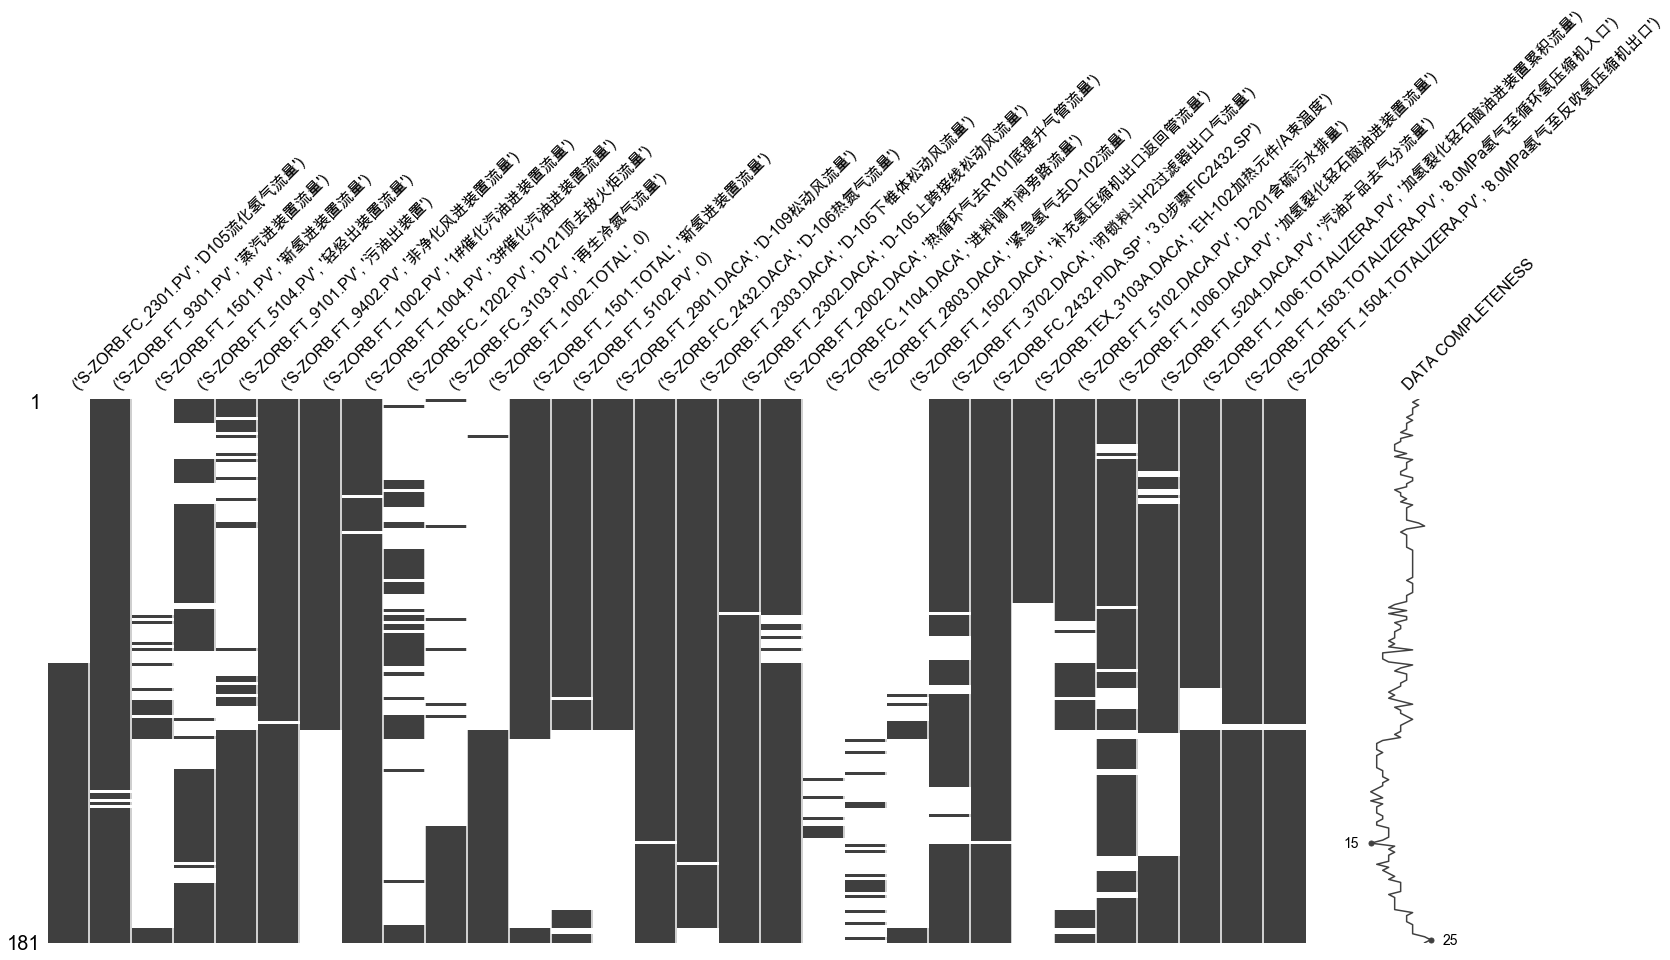

In [22]:
# 可视化呈现 样本数据 中属性中属性值存在零值的属性的分布
import missingno as msno
%matplotlib inline
msno.matrix(samples[samples_dummy_columns].replace(0, np.nan), labels=True)

结合背景信息和样本数据的时间分布，可以看做制作工艺优化过程中其属性被优化的过程，于是首先将大范围

In [23]:
# 对 缺失值较多属性值 的属性进行丢弃 对 缺失值较少属性值 的属性进行插值
# 缺失值比例
missing_value_ratio = 0.95  # 需要调整的参数
samples_delete_columns = []
samples_insert_columns = []
for (code_name, i18n_name) in samples_nonzeroratio.keys():
    if samples_nonzeroratio[(code_name, i18n_name)] < missing_value_ratio:
        # print(f"code_name: {code_name} => nonzero_ratio: {samples_nonzeroratio[(code_name, i18n_name)]}")
        samples_delete_columns.append((code_name, i18n_name))
    elif missing_value_ratio <= samples_nonzeroratio[(code_name, i18n_name)] < 1:
        samples_insert_columns.append((code_name, i18n_name))
# print(samples_insert_columns)
samples = samples.drop(columns=samples_delete_columns, axis=1)
samples.shape

(181, 349)

<AxesSubplot:>

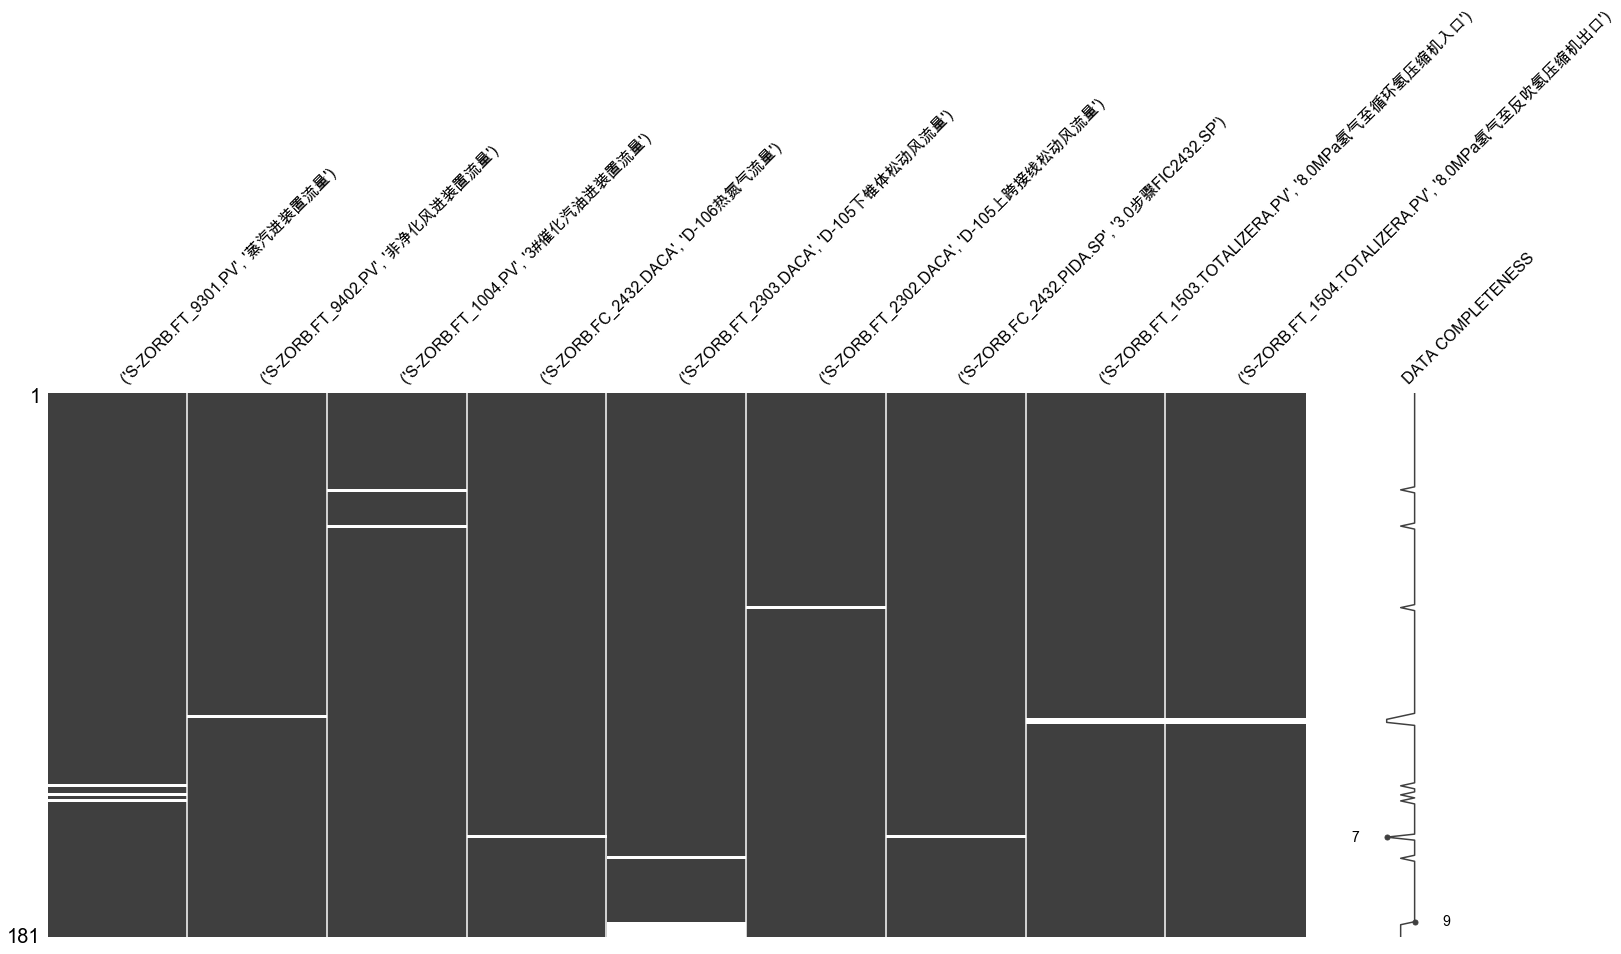

In [24]:
# 可视化呈现 样本数据 中属性中属性值需要进行填充的情况
import missingno as msno
%matplotlib inline
msno.matrix(samples[samples_insert_columns].replace(0, np.nan), labels=True)

In [25]:
# 使用线性方程对缺失的属性值进行插值操作
samples = samples.replace(0, np.nan).interpolate(method='linear')

<AxesSubplot:>

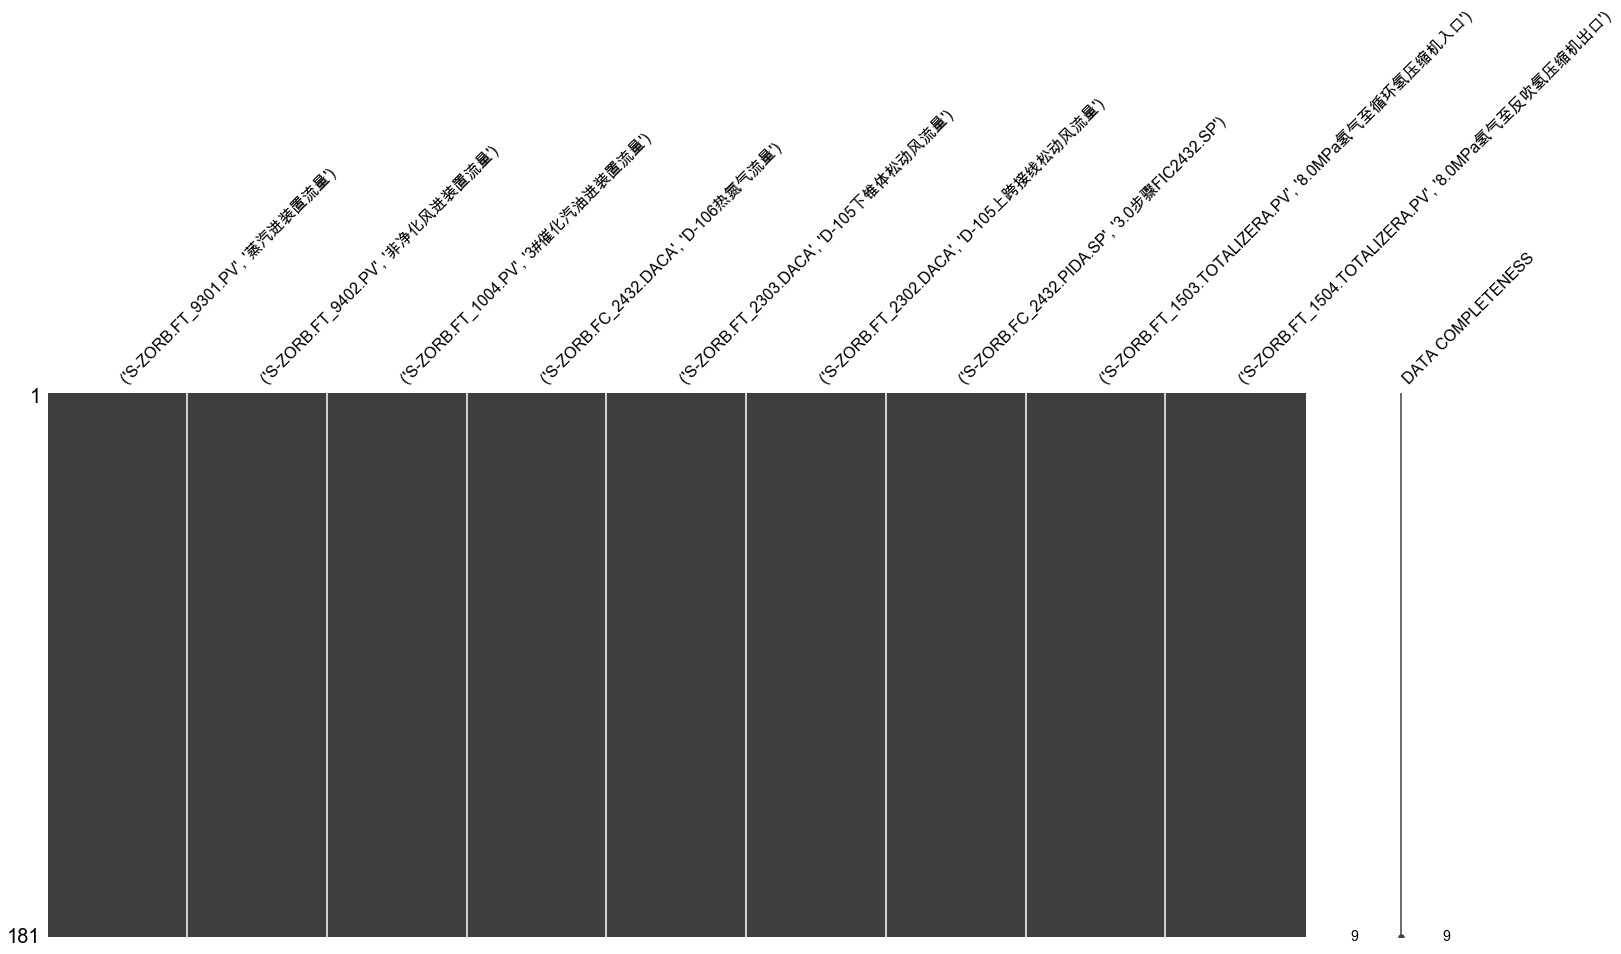

In [26]:
# 可视化呈现 样本数据 中属性中属性值插值的情况
import missingno as msno
%matplotlib inline
msno.matrix(samples[samples_insert_columns].replace(0, np.nan), labels=True)

In [27]:
# 提取 操作属性特征 同时 计算 每个属性与目标值的 相关系数，在 阈值 以下的属性将被丢弃
samples_features = samples.iloc[:, 2:]
source_features = samples_features[samples_features.columns[[x for x in range(0, 7)]]]
produc_features = samples_features[samples_features.columns[[x for x in range(7, 10)]]]
manule_features = samples_features[samples_features.columns[[x for x in range(14, samples_features.shape[1])]]]
# 相关系数的阈值
dist_standard1 = 0.2  # 需要调整的参数
manule_delete_columns = []
for (code_name, i18n_name) in manule_features.keys():
    target_feature_corr = produc_features[('产品性质', 'RON损失\n（不是变量）')].corr(manule_features[(code_name, i18n_name)])
    corr_dist = np.linalg.norm(target_feature_corr - 0)
    if corr_dist < dist_standard1:
        manule_delete_columns.append((code_name, i18n_name))
manule_features = manule_features.drop(manule_delete_columns, axis=1)

In [28]:
print(source_features.shape)
print(produc_features.shape)
print(manule_features.shape)

(181, 7)
(181, 3)
(181, 112)


In [29]:
y = produc_features[('产品性质', 'RON损失\n（不是变量）')].to_numpy()
X = manule_features.to_numpy()

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold,datasets
# 使用 T-SNE 进行数据降维
# X是特征，不包含target; X_tsne 是已经降维之后的特征
# 指定降维后的维数
re_dimension = 40  # 需要调整的参数
tsne = manifold.TSNE(n_components=re_dimension, perplexity=5, n_iter=6000, init='random', random_state=501, method="exact")
X_tsne = tsne.fit_transform(X)
print(f"原始样本数据维度 {X.shape[-1]}. t-SNE降维后的数据维度 {X_tsne.shape[-1]}")

原始样本数据维度 112. t-SNE降维后的数据维度 40


In [31]:
# 根据 新特征属性 与 辛烷值RON损失 的相关系数，筛选 相关系数 大于设定阈值的 新特征属性 作为构建函数目标属性
# 新特征属性 与 辛烷值RON损失 与 相关系数的阈值
dist_standard2 = 0.1  # 需要调整的参数
tSNE_features = pd.DataFrame(data=X_tsne, columns=[f'feature_{x + 1}' for x in range(re_dimension)])
const_features = []
for _ in tSNE_features.keys():
    RON_feature_corr = produc_features[('产品性质', 'RON损失\n（不是变量）')].corr(tSNE_features[_])
    corr_dist = np.linalg.norm(RON_feature_corr - 0)
    if -dist_standard2 > corr_dist or  corr_dist > dist_standard2:
        print(f"{'='*10} 特征名称: {_} {'='*10}")
        print(f"与 RON损失\n（不是变量） 的相关系数: {corr_dist}")
        const_features.append(_)
print(f"t-SNE feature is => {list(const_features)}")

========== 特征名称: feature_1 ==========
与 RON损失
（不是变量） 的相关系数: 0.16163912959447993
========== 特征名称: feature_8 ==========
与 RON损失
（不是变量） 的相关系数: 0.19336080176134507
========== 特征名称: feature_12 ==========
与 RON损失
（不是变量） 的相关系数: 0.10295335703623183
========== 特征名称: feature_17 ==========
与 RON损失
（不是变量） 的相关系数: 0.14268558598079414
========== 特征名称: feature_20 ==========
与 RON损失
（不是变量） 的相关系数: 0.15572525642436114
========== 特征名称: feature_22 ==========
与 RON损失
（不是变量） 的相关系数: 0.1529888203627981
========== 特征名称: feature_23 ==========
与 RON损失
（不是变量） 的相关系数: 0.11449487296855451
========== 特征名称: feature_24 ==========
与 RON损失
（不是变量） 的相关系数: 0.11942460573047722
========== 特征名称: feature_27 ==========
与 RON损失
（不是变量） 的相关系数: 0.16159152301354987
========== 特征名称: feature_31 ==========
与 RON损失
（不是变量） 的相关系数: 0.12203848291466467
========== 特征名称: feature_33 ==========
与 RON损失
（不是变量） 的相关系数: 0.13800539205787735
========== 特征名称: feature_34 ==========
与 RON损失
（不是变量） 的相关系数: 0.12467564045428822
========== 特征名称: feature_36 ===

In [32]:
# 新特征属性 与 原始属性 与 相关系数的阈值
dist_standard3 = 0.10  # 需要调整的参数
relate_features = set()
for _ in const_features:
    for (code_name, i18n_name) in manule_features.keys():
        cov_feature_corr = manule_features[(code_name, i18n_name)].corr(tSNE_features[_])
        if -dist_standard3 > cov_feature_corr or cov_feature_corr > dist_standard3:
            relate_features.add((code_name, i18n_name))
            
print(f"t-SNE feature relate to => {list(relate_features)}")

t-SNE feature relate to => [('S-ZORB.PDC_2502.PV', 'D107转剂线压差'), ('S-ZORB.PC_2401B.DACA', '闭锁料斗充氢线压力控制'), ('S-ZORB.FT_9001.PV', '燃料气进装置流量'), ('S-ZORB.FT_5201.PV', '产品汽油出装置流量'), ('S-ZORB.PT_6008.DACA', 'F-101辐射室出口压力'), ('S-ZORB.TE_5202.PV', '精制汽油出装置温度'), ('S-ZORB.FT_1003.PV', '2#催化汽油进装置流量'), ('S-ZORB.TE_1201.PV', 'D104温度'), ('S-ZORB.PT_2502.DACA', 'D-107底压力'), ('S-ZORB.TE_5101.DACA', 'A-201出口总管温度'), ('S-ZORB.FC_2432.DACA', 'D-106热氮气流量'), ('S-ZORB.PDI_2801.DACA', '还原器LH差压'), ('S-ZORB.FT_5101.PV', '干气出装置流量'), ('S-ZORB.PT_6002.PV', '加热炉炉膛压力'), ('S-ZORB.PT_1501.PV', 0), ('S-ZORB.FT_1001.PV', '催化汽油进装置总流量'), ('S-ZORB.FT_3301.PV', '除氧水进装置流量'), ('S-ZORB.PDC_2702.DACA', '再生器底部与再生接收器压差'), ('S-ZORB.AT-0005.DACA.PV', 'S_ZORB AT-0005'), ('S-ZORB.FC_5001.DACA', 'E203重沸器管程出口凝结水流量'), ('S-ZORB.PT_6005.DACA', 'F-101辐射室底部压力'), ('S-ZORB.TE_2104.DACA.PV', '过滤器ME-101出口温度'), ('S-ZORB.TE_5201.DACA', 'A-202A/B出口总管温度'), ('S-ZORB.PDT_2703B.DACA', '再生器接收器/LH差压'), ('S-ZORB.PDI_2105.DACA', '反吹气体聚集器/补充氢差压'), ('S-ZORB

### 问题三：

建立辛烷值（RON）损失预测模型：采用上述样本和建模主要变量，通过数据挖掘技术建立辛烷值（RON）损失预测模型，并进行模型验证。

In [33]:
# 尝试使用 多元线性回归 建模
# 构造训练集和测试集
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression  #线性回归
from sklearn.model_selection import train_test_split  #这里是引用了交叉验证
from sklearn import metrics
from sklearn.metrics.regression import mean_squared_error, r2_score

In [34]:
model_feature = manule_features[list(relate_features)]
# 变异系数
abnormal_ratio2 = 0.6  # 需要调整模型的时候参数
model_feature_describe = model_feature.describe()
temp_ratio = model_feature_describe.loc['std'] / model_feature_describe.loc['mean']
strong_feature = []
for (code_name, i18n_name) in temp_ratio.keys():
    if temp_ratio[(code_name, i18n_name)] > abnormal_ratio2:
        strong_feature.append((code_name, i18n_name))

model_feature = manule_features[list(strong_feature)]
model_features = model_feature.join(samples[[('原料性质', '辛烷值RON'), ('原料性质', '硫含量,μg/g'), ('产品性质', '辛烷值RON'), ('产品性质', 'RON损失\n（不是变量）')]])
model_features_describe = model_features.describe()
model_features_describe

S-ZORB.PDT_1003.DACA S-ZORB.PDT_1002.DACA S-ZORB.FT_2701.DACA  \
             P-101B入口过滤器差压        P-101A入口过滤器差压       D-110蒸汽盘管入口流量   
count           181.000000           181.000000          181.000000   
mean              6.342947             4.088910           29.863121   
std               4.003960             4.350143           18.880091   
min              -1.254199            -0.251661            3.419029   
25%               0.624742             0.025184           14.340726   
50%               8.740976             1.605800           19.462465   
75%               9.204491             9.330591           53.319419   
max              11.556480            11.562420           60.573262   

      S-ZORB.FT_2001.DACA S-ZORB.AT-0002.DACA.PV S-ZORB.AT-0001.DACA.PV  \
             紧急氢气去R-101流量         S_ZORB AT-0002         S_ZORB AT-0001   
count          181.000000             181.000000             181.000000   
mean             6.036636               2.744597               2.823550   
std             16.721159               3.109978               2.819194   
min             -7.724837               0.055274               0.498255   
25%             -0.424567               0.090930               0.535388   
50%             -0.194538               0.452997               0.557879   
75%             -0.017634               6.063571               6.137942   
max             64.773741               7.073580               7.153291   

             原料性质                    产品性质                
           辛烷值RON    硫含量,μg/g      辛烷值RON RON损失\n（不是变量）  
count  181.000000  181.000000  181.000000    181.000000  
mean    89.938398  233.852855   88.692044      1.246354  
std      0.861993   34.240226    0.887852      0.208641  
min     86.900000  162.285714   85.720000      0.440000  
25%     89.500000  210.000000   88.260000      1.120000  
50%     90.000000  241.000000   88.750000      1.220000  
75%     90.500000  258.692308   89.200000      1.340000  
max     91.700000  288.857143   90.420000      1.780000

In [35]:
strong_feature.append(('原料性质', '辛烷值RON'))
strong_feature.append(('原料性质', '硫含量,μg/g'))
X = model_features[list(strong_feature)]
y = model_features[[('产品性质', 'RON损失\n（不是变量）')]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
print('X_train.shape={}\ny_train.shape={}\nX_test.shape={}\ny_test.shape={}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train.shape=(135, 8)
y_train.shape=(135, 1)
X_test.shape=(46, 8)
y_test.shape=(46, 1)


In [36]:
# # Scaling data with 0 mean and 1 standard Deviation, so it can be observed easily
scaler = StandardScaler()
model_feature = scaler.fit_transform(model_feature)

In [37]:
# 简单线性回归
# Applying LinearRegression
linreg = LinearRegression()
model = linreg.fit(X_train, y_train)

In [38]:
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)
print ('MSE train:%.3f, test:%.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print ('R^2 train:%.3f, test:%.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train:0.034, test:0.043
R^2 train:0.225, test:-0.044


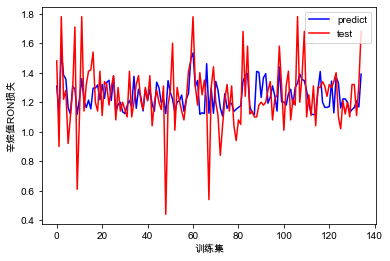

In [39]:
plt.figure()
plt.plot(range(len(y_train)), y_train_pred, 'b', label="predict")
plt.plot(range(len(y_train)), y_train, 'r', label="test")
plt.legend(loc = "upper right") #显示图中的标签
plt.xlabel("训练集")
plt.ylabel("辛烷值RON损失")
plt.show()

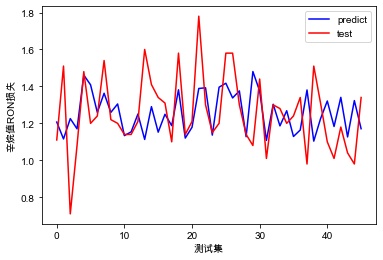

In [40]:
plt.figure()
plt.plot(range(len(y_test)), y_test_pred, 'b', label="predict")
plt.plot(range(len(y_test)), y_test, 'r', label="test")
plt.legend(loc = "upper right") #显示图中的标签
plt.xlabel("测试集")
plt.ylabel("辛烷值RON损失")
plt.show()

In [41]:
# 多项式回归
# Applying PolynomialFeatures
quadratic_featurizer = PolynomialFeatures(degree=2)
X_test_quadratic = quadratic_featurizer.fit_transform(X_test)
X_train_quadratic = quadratic_featurizer.fit_transform(X_train)

poly_linreg = LinearRegression()
poly_linreg.fit(X_train_quadratic, y_train)

LinearRegression()

In [42]:
y_test_pred = poly_linreg.predict(X_test_quadratic)
y_train_pred = poly_linreg.predict(X_train_quadratic)

print ('MSE train:%.3f, test:%.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print ('R^2 train:%.3f, test:%.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train:0.029, test:0.080
R^2 train:0.351, test:-0.947


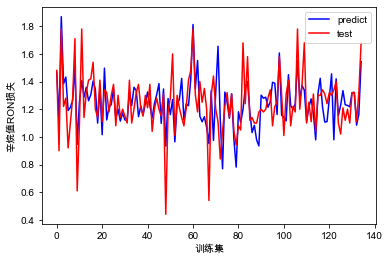

In [43]:
plt.figure()
plt.plot(range(len(y_train)), y_train_pred, 'b', label="predict")
plt.plot(range(len(y_train)), y_train, 'r', label="test")
plt.legend(loc = "upper right") #显示图中的标签
plt.xlabel("训练集")
plt.ylabel("辛烷值RON损失")
plt.show()

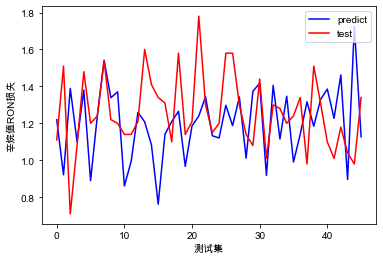

In [44]:
plt.figure()
plt.plot(range(len(y_test)), y_test_pred, 'b', label="predict")
plt.plot(range(len(y_test)), y_test, 'r', label="test")
plt.legend(loc = "upper right") #显示图中的标签
plt.xlabel("测试集")
plt.ylabel("辛烷值RON损失")
plt.show()